# Proyek Klasifikasi Gambar: Sea Animals Images
- **Nama:** Sayid Muhammad Heykal
- **Email:** heykalsayid@gmail.com
- **ID Dicoding:** heykalsayid

## Import Semua Packages/Library yang Digunakan

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import skimage
import random

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, random_shear, random_zoom
from sklearn.model_selection import train_test_split
from skimage import io, img_as_ubyte
from PIL import Image

import cv2
import os
import shutil
import time
import warnings

warnings.filterwarnings("ignore")
print(tf.__version__)
print(skimage.__version__)

#resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
#tf.tpu.experimental.initialize_tpu_system(resolver)
#strategy = tf.distribute.TPUStrategy(resolver)
#print("All devices: ", tf.config.list_logical_devices('TPU'))


2.16.1
0.23.2


In [5]:

!python --version

Python 3.10.14


## Data Preparation

### Data Loading

In [6]:
# define the base of input and output directory
# input: read-only directory, output: working directory
base_input = '/kaggle/input/sea-animals-images-augmented'
base_working = '/kaggle/working/'

In [ ]:
TEST_PATH = os.path.join(base_input, 'test')
TRAIN_PATH = os.path.join(base_input, 'train')

# list categoires
categories = os.listdir(TRAIN_PATH)

# assign train and test categories paths
train_categories_paths = [os.path.join(TRAIN_PATH, category) for category in categories]
test_categories_paths = [os.path.join(TEST_PATH, category) for category in categories]

In [ ]:
# moving all images into working directory
start_time = time.time()

# moving train data into all data
for num, path in enumerate(train_categories_paths):
    # define destination for directories to be copied
    destination = os.path.join(base_working, 'all_data', path.split('/')[-1])
    
    # check if path is directory
    if os.path.isdir(path):
        # copy directories and sub-dir to destination
        shutil.copytree(path, destination, dirs_exist_ok=True)
        print(f"\r ({num+1}/{len(train_categories_paths)}) {int(time.time() - start_time)}s Copied \33[32m{path}\33[0m to \33[35m{destination}\33[0m", end=" ")


In [9]:
# moving test data into all  data
start_time = time.time()
for num, path in enumerate(test_categories_paths):
    # define destination for directories to be copied
    destination = os.path.join(base_working, 'all_data', path.split('/')[-1])
    
    # check if path is directory
    if os.path.isdir(path):
        # copy directories and sub-dir to destination
        shutil.copytree(path, destination, dirs_exist_ok=True)
        print(f"\r ({num+1}/{len(test_categories_paths)}) {int(time.time() - start_time)}s Copied \33[32m{path}\33[0m to \33[35m{destination}\33[0m", end=" ")

 (23/23) 150s Copied /kaggle/input/prepared-training-images/sea-animals_images/test/Jelly Fish to /kaggle/working/all_data/Jelly Fish toise 

In [15]:
import zipfile
import os

# zip file to download
def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

# Example usage:
folder_to_zip = os.path.join(base_working, 'all_data')  # Replace with your folder path
output_zip_file = os.path.join(base_working, 'dall_data.zip')  # Replace with the desired output path
zip_folder(folder_to_zip, output_zip_file)

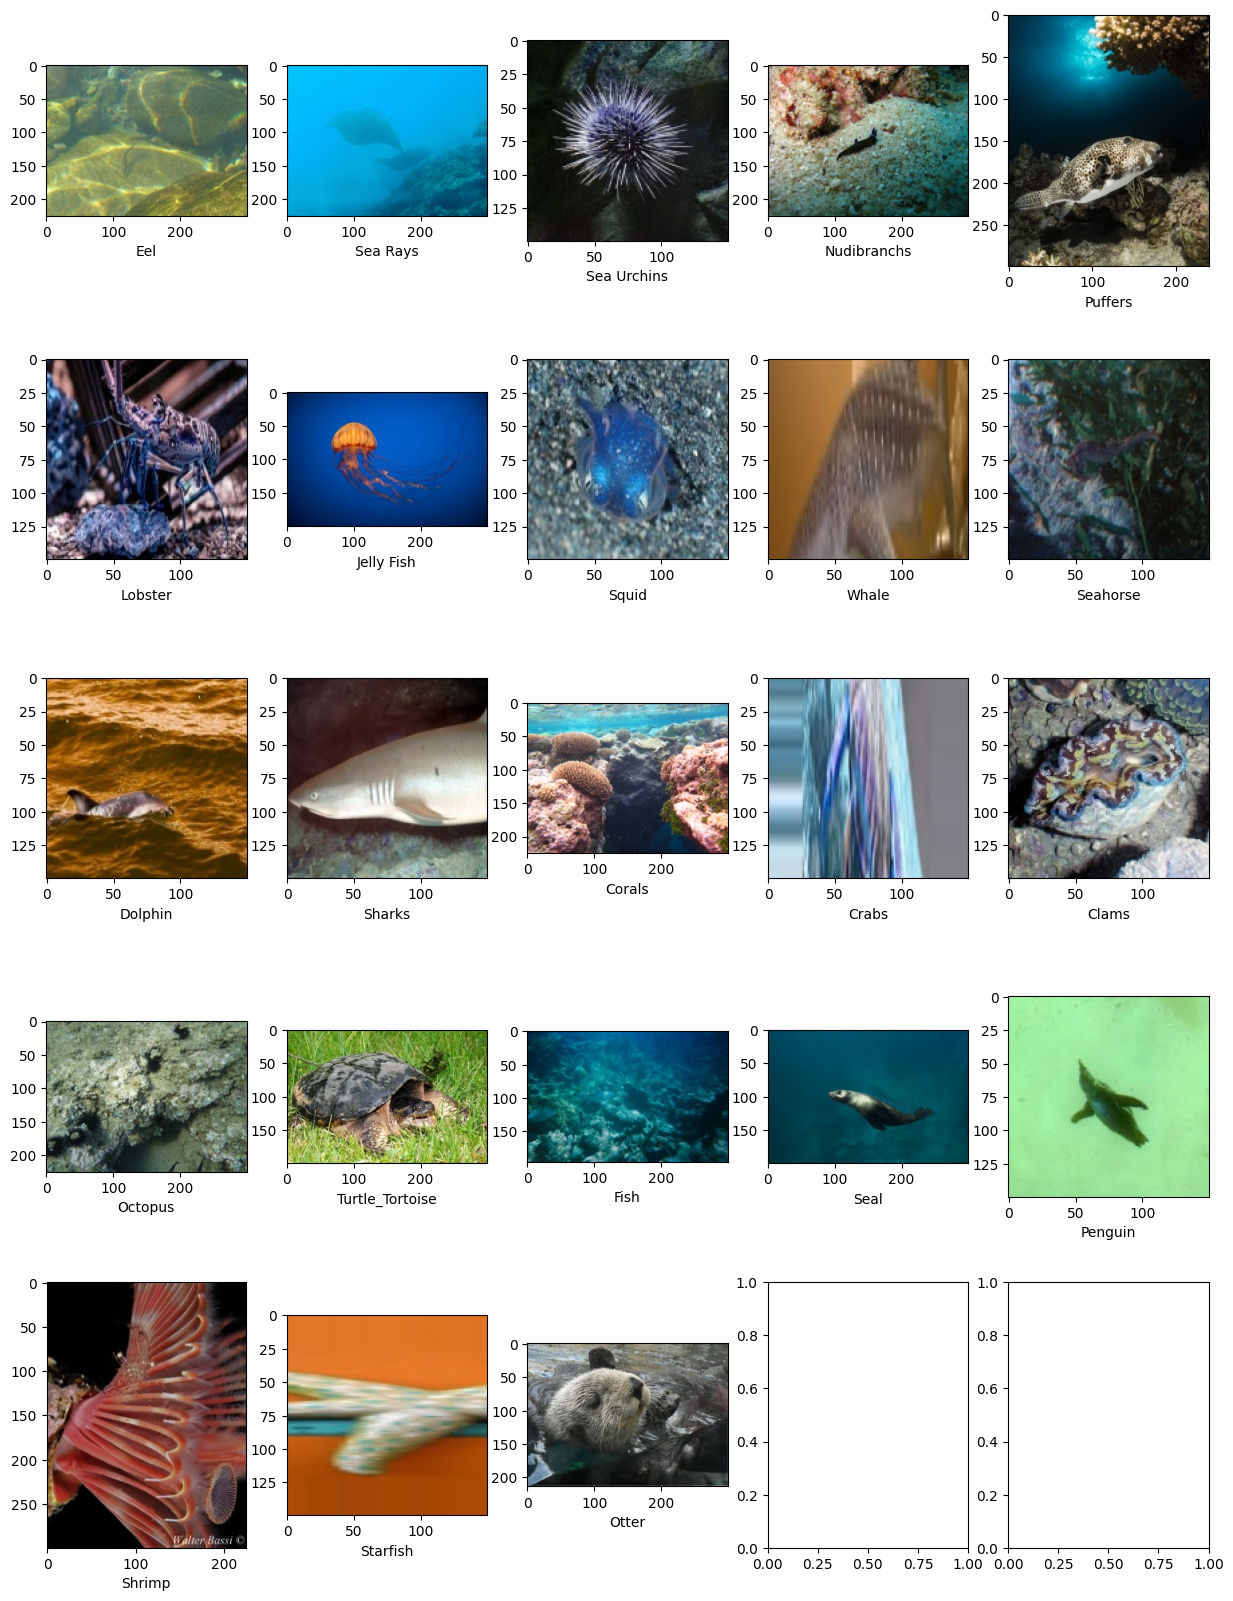

In [10]:
datasets_dir = base_working + "/all_data"
# redifine categories path in working directories
categories_path = [os.path.join(datasets_dir, class_name) for class_name in os.listdir(datasets_dir)]

# visualize random images from each categories
ncols = 5
nrows = (len(os.listdir(datasets_dir)) // 5) + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axs = axs.flatten()

i = 0
for category_path in categories_path:
    rand_img = np.random.choice(os.listdir(category_path))
    img = Image.open(os.path.join(category_path, rand_img)).convert('RGBA')
    axs[i].imshow(img)
    axs[i].set_xlabel(category_path.split('/')[-1])
    i += 1


In [11]:
file_paths = []
file_names = []
labels = []

for path in categories_path:
    for filename in os.listdir(path):
        file_names.append(filename)
        labels.append(path.split('/')[-1])
        file_paths.append(os.path.join(path, filename))

df = pd.DataFrame({'filepath' : file_paths, 'filename' : file_names, 'label' : labels})
print(f"Number of labels: {len(df['label'].unique())}")
print(f"Number of images: {len(df)}")
df.head()

Number of labels: 23
Number of images: 25158


,filepath,filename,label
0,/kaggle/working//all_data/Eel/231793502_611d45...,231793502_611d455435_b.jpg,Eel
1,/kaggle/working//all_data/Eel/4155234224_2c553...,4155234224_2c5530c11e_o.jpg,Eel
2,/kaggle/working//all_data/Eel/5117557932_83af0...,5117557932_83af06dd74_o.jpg,Eel
3,/kaggle/working//all_data/Eel/45233357731_fc80...,45233357731_fc80d414df_o.jpg,Eel
4,/kaggle/working//all_data/Eel/augmented_677362...,augmented_6773624728_271afcdbbf_o.jpg,Eel


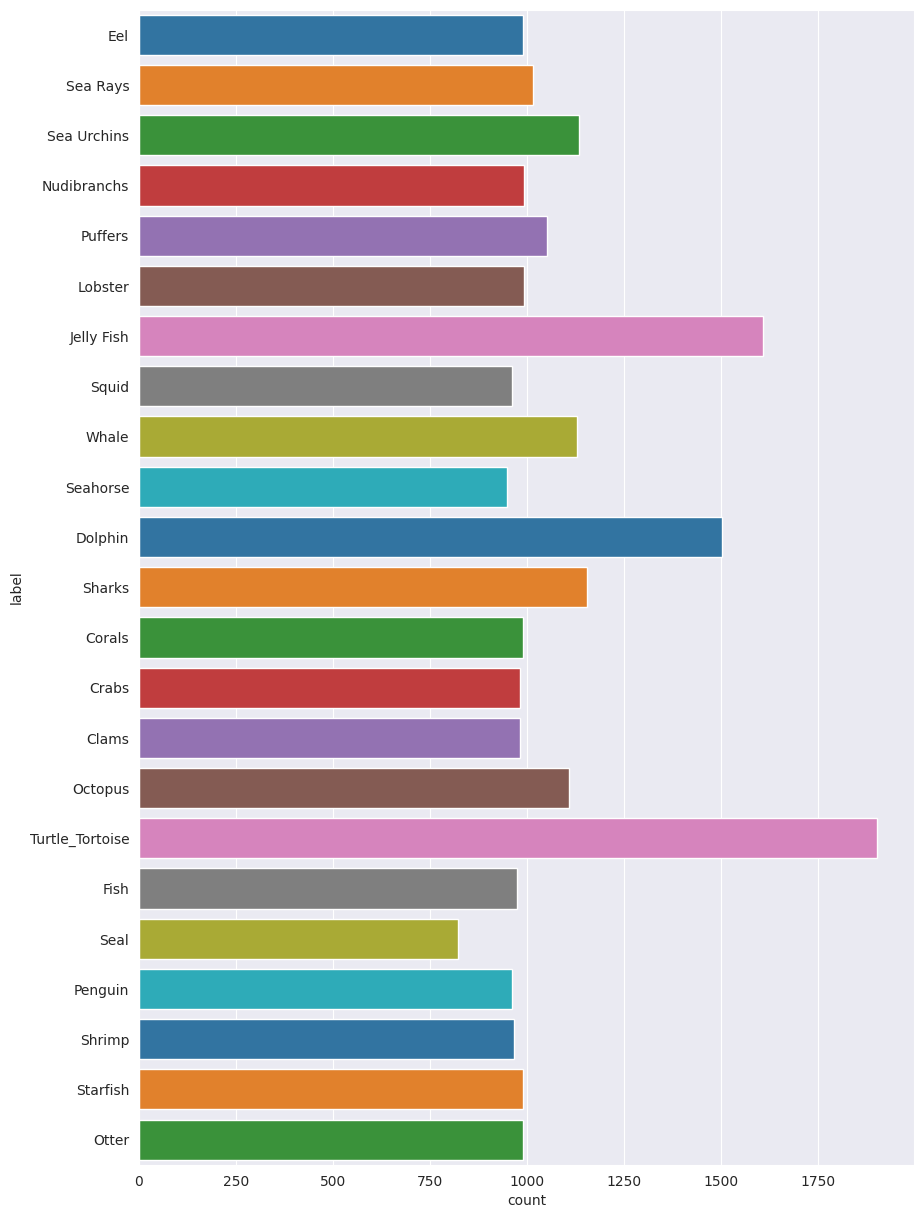

In [12]:
def plot_distribution(df, labels, palette=sns.color_palette()):
    plt.figure(figsize=(10,15))
    sns.set_style('darkgrid')
    sns.countplot(data=df, y=labels, hue_order=labels, palette=palette)

plot_distribution(df, 'label')

### Data Preprocessing

In [13]:
df.sample(5)

,filepath,filename,label
16084,/kaggle/working//all_data/Clams/augmented_1490...,augmented_14909116883_b83473b6ce_o.jpg,Clams
10083,/kaggle/working//all_data/Seahorse/116569530_8...,116569530_8ef1bb67ee_b.jpg,Seahorse
21336,/kaggle/working//all_data/Penguin/8270085329_9...,8270085329_97920f3cdb_o.jpg,Penguin
16488,/kaggle/working//all_data/Octopus/30971228880_...,30971228880_ab3ffa532f_b.jpg,Octopus
21516,/kaggle/working//all_data/Penguin/augmented_68...,augmented_6875776772_bdcc03359a_b.jpg,Penguin


## **Generate a new images through the transformations**

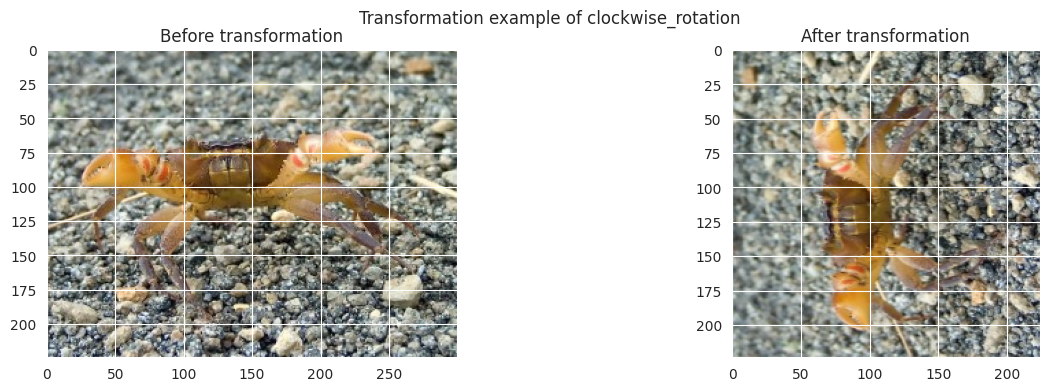

In [18]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
# define resize shape
resize_shape = (224, 224)

# clockwise rotation augmentation
def clockwise_rotation(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return img

# flip the image up and down
def flip_up_down(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.flip_up_down(img)
    return img

# flip the iamge left and right
def flip_left_right(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.flip_left_right(img)
    return img

# add the image brightness
def add_brightness(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    return img

# Share the iamge randomly
def sheared(img):
    img = tf.image.resize(img, resize_shape)
    img = random_shear(img, intensity=0.2)
    return img

# zoom the image
def zoomed(img):
    img = tf.image.resize(img, resize_shape)
    img = random_zoom(img, zoom_range=[0, 2], row_axis=0, col_axis=1, channel_axis=2)
    return img


# Plot the transformation
def plot_transformation(img, transformation):
    key = transformation
    # read the image file
    image = io.imread(image_path)

    # convert an image into tensor and normalize
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0

    # apply transformation of the image
    img_transformed = transformations[key](image)

    # plot the original and transformed image
    fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
    fig.suptitle(f"Transformation example of {transformation}")
    ax[0].imshow(image)
    ax[0].set_title('Before transformation')
    ax[1].imshow(img_transformed)
    ax[1].set_title('After transformation')


# Define all transformation in variable
transformations = {
    'clockwise_rotation' : clockwise_rotation,
    'flip_up_down' : flip_up_down,
    'flip_left_right' : flip_left_right,
    'add_brightness' : add_brightness,
    'sheared' : sheared,
    'zoomed' : zoomed,
}
    
# Load image
image_path = categories_path[0] + '/' + os.listdir(categories_path[0])[0]
plot_transformation(image_path, transformation='clockwise_rotation')

In [19]:
def augment_image(original_image):
    # Ensure TensorFlow operations
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32) / 255.0
    transformed_count = random.randint(1, len(transformations))
    for _ in range(transformed_count):
        key = random.choice(list(transformations.keys()))
        original_image = transformations[key](original_image)
    return original_image


BASE_DIR = os.path.join(base_working, 'all_data')
paths_to_generate = [path for path in categories_path if path.split('/')[-1] != 'Turtle_Tortoise']

with strategy.scope():
    start_time = time.time()
    for num, path in enumerate(paths_to_generate):
        num_image_to_generate = 2000
        images_path = [os.path.join(path, im) for im in os.listdir(path)]
        
        i = 0
        while i < num_image_to_generate:
            try:
                original_image_path = random.choice(images_path)
                original_image = io.imread(original_image_path)
                
                # Augment image within TPU scope
                image_transformed = augment_image(original_image)
                
                # Normalize and convert to uint8 for saving
                image_transformed = (image_transformed - tf.reduce_min(image_transformed)) / \
                                    (tf.reduce_max(image_transformed) - tf.reduce_min(image_transformed))
                image_transformed = tf.image.convert_image_dtype(image_transformed, dtype=tf.uint8).numpy()
                
                # Save augmented image
                image_transformed_path = f"{BASE_DIR}/{path.split('/')[-1]}/augmented_{os.path.basename(original_image_path)}"
                cv2.imwrite(image_transformed_path, image_transformed)
                
                i += 1
                print(f"\r({num}/{len(paths_to_generate)}) {int(time.time() - start_time)}s Generate image [{path.split('/')[-1]}] ({i}/{num_image_to_generate})", end=" ")
            except Exception as e:
                pass

# #Optimize Data Loading
# def load_image(image_path):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_image(image, channels=3)
#     return image

# image_dataset = tf.data.Dataset.from_tensor_slices(images_path).map(load_image).batch(128)

(21/22) 3097s Generate image [Seahorse] (2000/2000) 0) 

In [8]:
BASE_DIR = '/kaggle/input/sea-animals-images-augmented'

RESIZE_SHAPE = (224, 224)
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

with strategy.scope():
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                        validation_split=0.2)
    
    train_generator = train_datagen.flow_from_directory(
        BASE_DIR,
        target_size=RESIZE_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        subset='training',
    )
    
    valid_generator = train_datagen.flow_from_directory(
        BASE_DIR,
        target_size=RESIZE_SHAPE,
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        shuffle=False,
        subset='validation',
    )

Found 20134 images belonging to 23 classes.
Found 5024 images belonging to 23 classes.


In [9]:
train_generator.class_indices

{'Clams': 0,
 'Corals': 1,
 'Crabs': 2,
 'Dolphin': 3,
 'Eel': 4,
 'Fish': 5,
 'Jelly Fish': 6,
 'Lobster': 7,
 'Nudibranchs': 8,
 'Octopus': 9,
 'Otter': 10,
 'Penguin': 11,
 'Puffers': 12,
 'Sea Rays': 13,
 'Sea Urchins': 14,
 'Seahorse': 15,
 'Seal': 16,
 'Sharks': 17,
 'Shrimp': 18,
 'Squid': 19,
 'Starfish': 20,
 'Turtle_Tortoise': 21,
 'Whale': 22}

## Modelling

In [10]:
from tensorflow.keras.applications import MobileNet, ResNet50V2

with strategy.scope():
    base_model = ResNet50V2(
        input_shape=(224, 224, 3),
        weights="imagenet",
        include_top=False)
    
    base_model.trainable = False
    
    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-10:]:  # Adjust the number of layers to unfreeze
        layer.trainable = True
        
    model = Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),
        base_model,
        tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(23, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
model.summary()


I0000 00:00:1734618057.128393      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 16)       │       819,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │           759 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,385,511 (93.02 MB)

 Trainable params: 4,236,679 (16.16 MB)

 Non-trainable params: 20,148,832 (76.86 MB)

In [14]:
from tensorflow.keras.callbacks import Callback
from datetime import datetime

curr_time = datetime.now()
v_format = curr_time.date().strftime("%d") +'_'+ curr_time.time().strftime("%H")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=base_working + "/ckpt/model_{epoch:02d}_{accuracy:.2f}_{val_accuracy:.2f}_v"+ v_format + ".keras",
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=2,
                              patience=5, min_lr=0.0001)


class EarlyStoppingOnTarget(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        # Ensure metrics are not None before comparison
        if acc is not None and val_acc is not None:
            if acc >= 96 and val_acc >= 96:
                print(f"Stopping training: Reached accuracy {acc}% and validation accuracy {val_acc}%.")
                self.model.stop_training = True

In [15]:
with tf.device('/TPU:0'):
    history = model.fit(train_generator, epochs=50,
                        batch_size=BATCH_SIZE,
                        validation_data=valid_generator, 
                        steps_per_epoch=train_generator.samples // BATCH_SIZE,
                        callbacks=[model_checkpoint,  reduce_lr])

Epoch 1/50


2024-12-19 14:23:28.518354: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1734618209.544298     799 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(93ec690e8b8d74d7:0:0), session_name()


 1/39 ━━━━━━━━━━━━━━━━━━━━ 9:36 15s/step - accuracy: 0.0000e+00 - loss: 49.0885

I0000 00:00:1734618218.427817     799 tpu_compile_op_common.cc:245] Compilation of 93ec690e8b8d74d7:0:0 with session name  took 8.883464844s and succeeded
I0000 00:00:1734618218.453852     799 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(93ec690e8b8d74d7:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6160381453106011693", property.function_library_fingerprint = 7036678822454620349, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "64,224,224,3,;64,23,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734618218.453903     799 tpu_compilation_cache_interface.cc:541] After adding entry for key

25/39 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.4793 - loss: 46.0197

I0000 00:00:1734618285.287941     803 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1cd8fce4489ce8ee:0:0), session_name()


26/39 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.4854 - loss: 45.9448

I0000 00:00:1734618294.142477     803 tpu_compile_op_common.cc:245] Compilation of 1cd8fce4489ce8ee:0:0 with session name  took 8.854467198s and succeeded
I0000 00:00:1734618294.173472     803 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1cd8fce4489ce8ee:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6160381453106011693", property.function_library_fingerprint = 7036678822454620349, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "21,224,224,3,;21,23,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734618294.173518     803 tpu_compilation_cache_interface.cc:541] After adding entry for key

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5482 - loss: 44.9956

2024-12-19 14:25:22.025300: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Abs/ReadVariableOp.
I0000 00:00:1734618324.198196     784 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c85e352c18f968bb:0:0), session_name()
I0000 00:00:1734618328.834085     784 tpu_compile_op_common.cc:245] Compilation of c85e352c18f968bb:0:0 with session name  took 4.635847156s and succeeded
I0000 00:00:1734618328.844155     784 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c85e352c18f968bb:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15097305725041871489", property.function_library_fingerprint = 11169752694809822834, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, 


Epoch 1: val_accuracy improved from -inf to 0.71019, saving model to /kaggle/working//ckpt/model_01_0.70_0.71_v19_14.keras


I0000 00:00:1734618354.769223     835 tpu_compile_op_common.cc:245] Compilation of db3a3a2b1dfe4a9:0:0 with session name  took 4.193132252s and succeeded
I0000 00:00:1734618354.780981     835 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(db3a3a2b1dfe4a9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15097305725041871489", property.function_library_fingerprint = 11169752694809822834, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "52,224,224,3,;52,23,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734618354.781019     835 tpu_compilation_cache_interface.cc:541] After adding entry for key

39/39 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.5520 - loss: 44.9279 - val_accuracy: 0.7102 - val_loss: 37.6640 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.71019
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 526ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7102 - val_loss: 37.6640 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8851 - loss: 34.8126
Epoch 3: val_accuracy improved from 0.71019 to 0.76274, saving model to /kaggle/working//ckpt/model_03_0.90_0.76_v19_14.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8855 - loss: 34.7581 - val_accuracy: 0.7627 - val_loss: 29.0840 - learning_rate: 0.0010
Epoch 4/50
 1/39 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.9219 - loss: 28.2856
Epoch 4: val_accuracy did not improve from 0.76274
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.9219 - loss: 28.2856 - val_accuracy: 0.7468 - val_loss: 28.8933 - learning_rate: 0.0010
Epoch 5/50


## Evaluasi dan Visualisasi

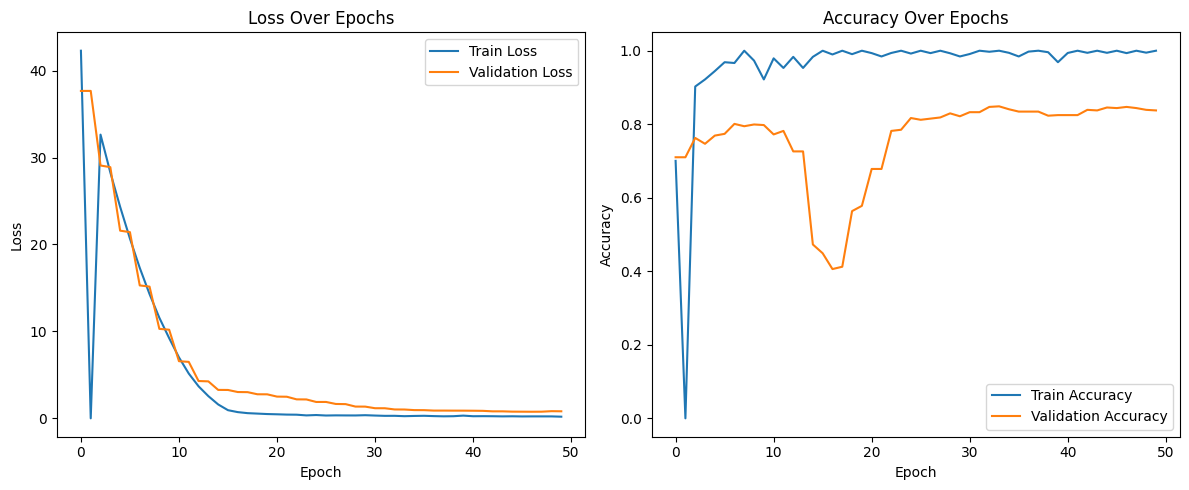

In [16]:
# Plot training train_history
plt.figure(figsize=(12, 5))
train_history = history.history
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_history["loss"], label="Train Loss")
plt.plot(train_history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_history["accuracy"], label="Train Accuracy")
plt.plot(train_history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
load_model_path = '/kaggle/input/model-resnet50v2-80-20-split-tf2/tensorflow2/default/1/model_34_1.00_0.85_v19_14.keras'
model_final = tf.keras.models.load_model(load_model_path, safe_mode=False)
model_final.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 16)       │       819,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │           759 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,858,871 (125.35 MB)

 Trainable params: 4,236,679 (16.16 MB)

 Non-trainable params: 20,148,832 (76.86 MB)

 Optimizer params: 8,473,360 (32.32 MB)

## Konversi Model

In [8]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.2 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 

In [9]:
import zipfile
import tensorflow as tf
import os

def zip_folder(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            print(root)
            for file in files:
                print('--' + file)
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))
                
    print("Folder zipped successfully!")

## SavedModel

In [10]:
savedmodel_path = '/kaggle/working/savedmodel'
tf.saved_model.save(model_final, savedmodel_path)

savedmodel_zip = f'{base_working}/savedmodel.zip'
zip_folder(savedmodel_path, savedmodel_zip)

/kaggle/working/savedmodel
--fingerprint.pb
--saved_model.pb
/kaggle/working/savedmodel/assets
/kaggle/working/savedmodel/variables
--variables.data-00000-of-00001
--variables.index
Folder zipped successfully!


## TFJS Converter

In [11]:
import tensorflowjs as tfjs

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    savedmodel \
    web_model

zip_folder('web_model', 'web_model.zip')

web_model
--model.json
--group1-shard18of24.bin
--group1-shard5of24.bin
--group1-shard11of24.bin
--group1-shard19of24.bin
--group1-shard3of24.bin
--group1-shard14of24.bin
--group1-shard9of24.bin
--group1-shard13of24.bin
--group1-shard21of24.bin
--group1-shard4of24.bin
--group1-shard20of24.bin
--group1-shard1of24.bin
--group1-shard23of24.bin
--group1-shard15of24.bin
--group1-shard24of24.bin
--group1-shard16of24.bin
--group1-shard8of24.bin
--group1-shard12of24.bin
--group1-shard2of24.bin
--group1-shard7of24.bin
--group1-shard22of24.bin
--group1-shard17of24.bin
--group1-shard10of24.bin
--group1-shard6of24.bin
Folder zipped successfully!


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('savedmodel')
tflite_model = converter.convert()
 
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)